In [1]:
!ln -s /content/drive/MyDrive/Colab\ Notebooks/Mobile-Unet/utils ./
!ln -s /content/drive/MyDrive/OkraInsight/training_data ./
!ln -s /content/drive/MyDrive/OkraInsight/.ipynb_checkpoints ./

import argparse
import logging
import os
import random
import sys
import glob
import cv2
import pickle
import torch

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt


from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split


from utils.data_loading import BasicDataset, OkraDataset

ln: failed to create symbolic link './utils': File exists
ln: failed to create symbolic link './training_data': File exists
ln: failed to create symbolic link './.ipynb_checkpoints': File exists


In [2]:
# 1. Create dataset
dir_img = Path('./training_data/okra_images/class_okra_surface')
dir_mask = Path('./training_data/okra_segmentation_target_masks')
dir_checkpoint = Path('./checkpoint')
img_scale = 0.1
dataset = OkraDataset(dir_img, dir_mask, img_scale)

100%|██████████| 31/31 [00:04<00:00,  7.27it/s]


In [3]:
# 2. Split into train / validation partitions
# val_percent = 0.1
# n_val = int(len(dataset) * val_percent)
# n_train = len(dataset) - n_val
# print("n_val = ", n_val, ", n_train = ", n_train)
# train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

In [3]:
# 3. Create data loaders
batch_size = 1
loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
test_loader = DataLoader(dataset, shuffle=False, drop_last=True, **loader_args)

# batch_size = 2 ==> torch.Size([2, 3, 3024, 4032]) x18
# batch_size = 3 ==> torch.Size([3, 3, 3024, 4032]) x12
#
# for batch in train_loader:
#  images, true_masks = batch['image'], batch['mask']
#  print(images.shape)

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_image_with_mask(image, mask, iter_cnt, img_name):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    plt.title(f"Mask for image # {iter_cnt} {img_name}", fontsize=18)
    # plt.axis('off')
    plt.show()

In [25]:
#if __name__ == "__main__":
#  class Args(argparse.Namespace):
#    model='deeplabv3_mobilenet_v3_large'

#  args = Args()

#num_segment_classes = 1
#model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', progress=True, pretrained=False, num_classes=1)

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.01, weight_decay=1e-8)

#checkpoint = torch.load('./.ipynb_checkpoints/deeplab_v3_training_checkpoint.pth')
#model.load_state_dict(checkpoint['model'])

#scriptedm = torch.jit.script(model)
#torch.jit.save(scriptedm, 'deeplabv3_scripted.pt')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [5]:
model = torch.load('.ipynb_checkpoints/deeplabv3_scripted.pt')

# use deeplabv3_resnet50 instead of deeplabv3_resnet101 to reduce the model size
# model = torch.hub.load('pytorch/vision:v0.8.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torch/serialization.py:799: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


RecursiveScriptModule(
  original_name=DeepLabV3
  (backbone): RecursiveScriptModule(
    original_name=IntermediateLayerGetter
    (0): RecursiveScriptModule(
      original_name=Conv2dNormActivation
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=BatchNorm2d)
      (2): RecursiveScriptModule(original_name=Hardswish)
    )
    (1): RecursiveScriptModule(
      original_name=InvertedResidual
      (block): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=Conv2dNormActivation
          (0): RecursiveScriptModule(original_name=Conv2d)
          (1): RecursiveScriptModule(original_name=BatchNorm2d)
          (2): RecursiveScriptModule(original_name=ReLU)
        )
        (1): RecursiveScriptModule(
          original_name=Conv2dNormActivation
          (0): RecursiveScriptModule(original_name=Conv2d)
          (1): RecursiveScriptModule(original_name=BatchNorm2d)
     

In [7]:
# preprocess = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

it = iter(test_loader)
iter_cnt = 0

In [31]:
try:
  sample_batch = next(it)
  iter_cnt += 1
  print("image # ", iter_cnt)
except StopIteration:
  print("Reached end of iteration. last count is ", iter_cnt)
except Exception as e: print(e)

image #  12


images.shape =  <class 'torch.Tensor'> torch.float32 torch.Size([3, 302, 403])
true_masks.shape =  <class 'torch.Tensor'> torch.bool torch.Size([1, 302, 403])


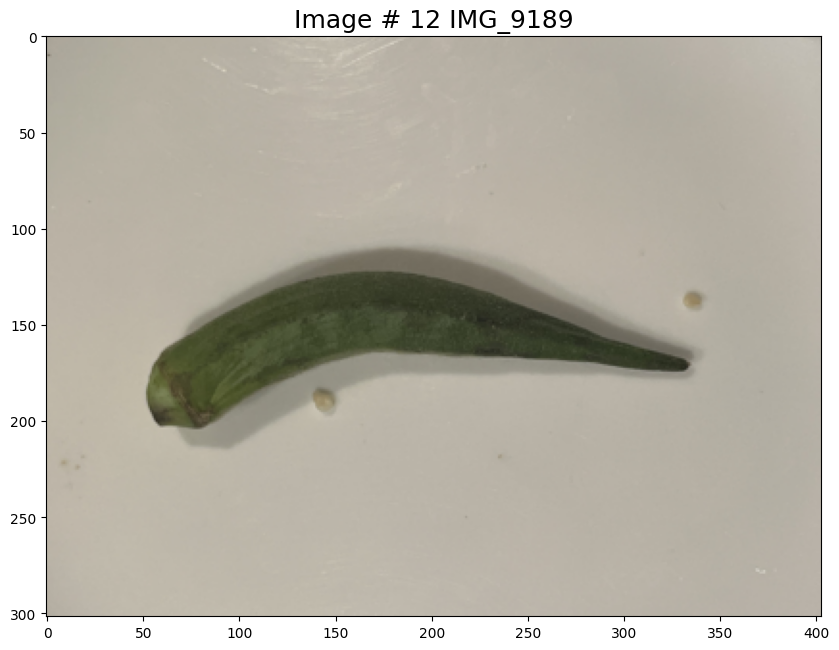

In [32]:
image, mask = sample_batch['image'], sample_batch['mask']

img_tensor = image.squeeze(0)
img_nparray = img_tensor.permute(1, 2, 0).numpy()

neg_mask = ~mask

print("images.shape = ", type(img_tensor) , img_tensor.dtype , img_tensor.shape)
print("true_masks.shape = ", type(mask), mask.dtype, mask.shape)

plt.figure(figsize=(10,10))
img_name = dataset.ids[iter_cnt - 1]
plt.title(f"Image # {iter_cnt} {img_name}", fontsize=18)
plt.imshow(img_nparray)

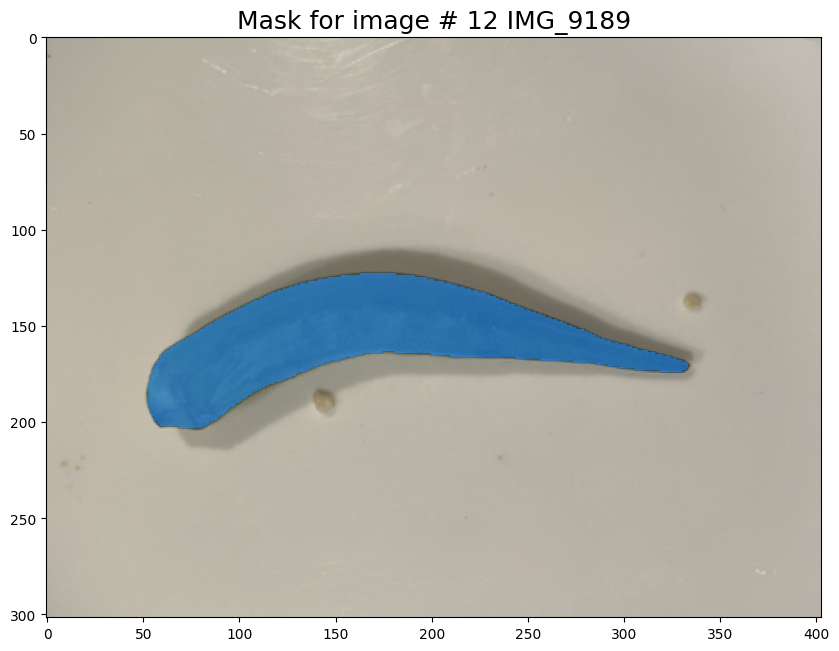

In [33]:
show_image_with_mask(img_nparray, mask, iter_cnt, img_name)

In [34]:
# model.eval()
mask_pred = model(image)['out'].detach()

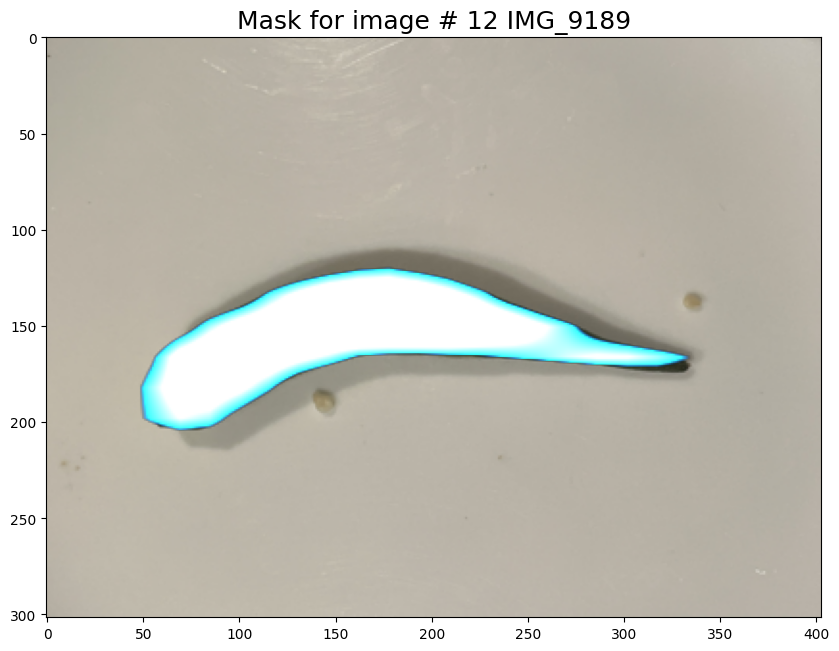

In [35]:
show_image_with_mask(img_nparray, mask_pred, iter_cnt, img_name)

In [33]:
# scriptedm = torch.jit.script(model)
# torch.jit.save(scriptedm, 'ipynb_checkpoints/deeplabv3_scripted.pt')

In [43]:
#!cp 'deeplabv3_scripted.pt' .ipynb_checkpoints/